## Question 3 - Do more experienced players spend more time thinking?

More experienced players have the advantage over less experienced players because they are both able to analyze the position faster and consider more possible lines. Being able to analyze the position faster should lead to faster games, while being able to see more lines should lead to slower games. We wish to see what the overall effect is.

To answer this question, we instead consider a similar question: Do more experienced players use up more of their time? Consider a specific time control. Take rapid, specifically 10+0 games, where thinking for over a minute is not that uncommon. We want players to have some time to think so we can accurately gauge their ability.

We look specifically at the combined thinking time of the two players in the game. (We can look at whether there is correlation between the amount of time each player's clock ticks for another question.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Data Preprocessing and Loading

First, we load in the data. We can filter for the 10+0 games only. The only columns that we are interested in are
- the clock,
- the players' elo, and \\
(planning for future sub-questions)
- number of moves in the game.

We also need to use
- time control \\
to load in the filtered rows.

In [2]:
url = "https://csslab.cs.toronto.edu/data/chess/monthly/lichess_db_standard_rated_2019-01.csv.bz2"

# define the conditions to filter the rows
condition = lambda df: df['time_control'] == '600+0'

# only read in these rows in each chunk
filtered_chunks = []
max_chunks = 40
chunksize = 1e6
chunk_counter = 0
columns_to_load = ['game_id', 'clock', 'num_ply', 'termination', 'white_elo', 'black_elo', 'time_control']
dtype = {'game_id':str, 'clock':'Int64', 'num_ply':int, 'termination':str, 'white_elo':int, 'black_elo':int, 'time_control':str}

start_time = time.time()
for chunk in pd.read_csv(url, compression='bz2', usecols = columns_to_load, chunksize=chunksize, dtype=dtype):
    filtered_chunk = chunk[condition(chunk)]
    filtered_chunks.append(filtered_chunk)
    chunk_counter += 1

    if chunk_counter >= max_chunks:
        break

df = pd.concat(filtered_chunks, ignore_index=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to process the first {chunk_counter} chunks: {elapsed_time:.2f} seconds")

print(df.shape)
df.head()

Time taken to process the first 40 chunks: 692.43 seconds
(7335026, 7)


,game_id,white_elo,black_elo,time_control,num_ply,termination,clock
0,mAEz2AcC,1702,1628,600+0,36,Normal,600
1,mAEz2AcC,1702,1628,600+0,36,Normal,600
2,mAEz2AcC,1702,1628,600+0,36,Normal,598
3,mAEz2AcC,1702,1628,600+0,36,Normal,599
4,mAEz2AcC,1702,1628,600+0,36,Normal,596


For each game, we want to calculate the number of seconds that the game lasted for after Black's first move. To calculate this, we note that the termination column takes two values, Normal for most games, and Time forfeit for games where a player lost because they ran out of time. Thus, we write the following helper function to calculate for each game, how long the game lasted.

In [3]:
def calculate_duration(game):
    termination = game['termination'].iloc[0]
    if termination == 'time forfeit':
        return 1200 - game['clock'].iloc[-1]
    else:
        return 1200 - (game['clock'].iloc[-1] + game['clock'].iloc[-2])

df_compressed = df.groupby('game_id').apply(calculate_duration, include_groups=False).reset_index(name='duration')
df_compressed = pd.merge(df_compressed[['game_id', 'duration']],
                         df[['game_id', 'white_elo', 'black_elo', 'num_ply', 'termination']],
                         on='game_id', how='left').drop_duplicates(subset='game_id', ignore_index=True)

df_compressed['elo'] = df_compressed[['white_elo', 'black_elo']].mean(axis=1)
df_compressed.drop(columns=['white_elo', 'black_elo', 'termination'], inplace=True)

df_compressed.head()

,game_id,duration,num_ply,elo
0,0002eNqP,619,38,1664.5
1,000AQ6GG,499,57,1335.0
2,001QYJhZ,954,63,1146.0
3,0059ikZy,767,67,898.0
4,005ZOW5z,338,50,1431.5


Now, graph the distribution of elo on the X and time leftover at the game end on the Y.

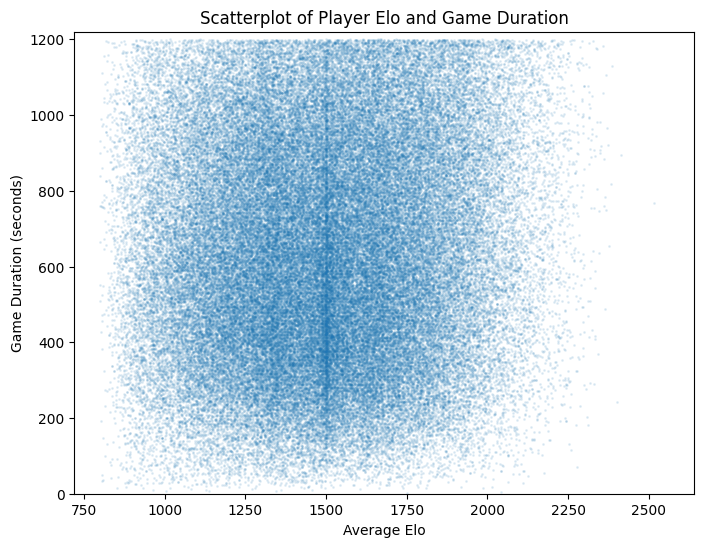

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(df_compressed['elo'], df_compressed['duration'], s=1.2, alpha=0.1)
plt.xlabel("Average Elo")
plt.ylabel("Game Duration (seconds)")
plt.title("Scatterplot of Player Elo and Game Duration")
plt.xlim(df_compressed['elo'].min() * 0.9, df_compressed['elo'].max() * 1.05)
plt.ylim(0, 1220)
plt.show()

This is difficult to interpret, so let's make a heatmap.

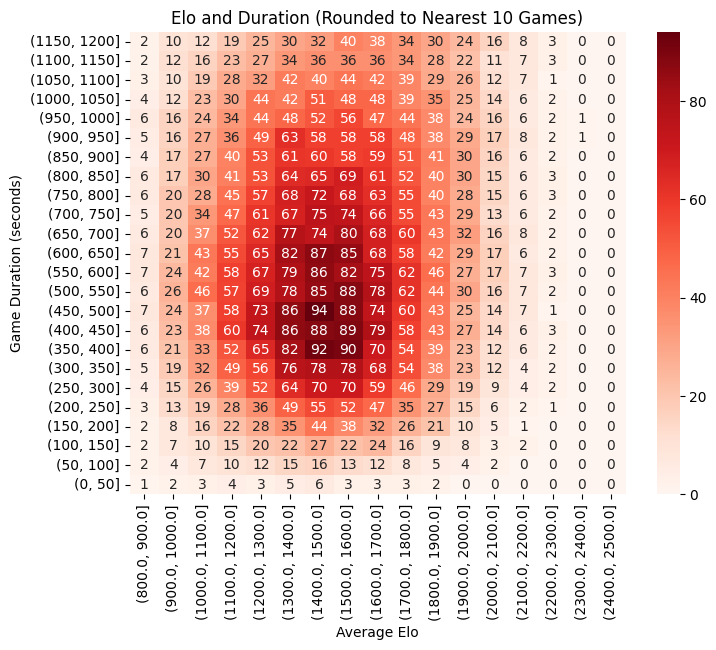

In [31]:
elo_bins = np.arange(100 * np.floor(df_compressed['elo'].min() / 100),
                     100 * np.ceil(df_compressed['elo'].max() / 100),
                     100)
time_bins = np.arange(0, 1201, 50)

# Bin the data
df_compressed['elo_bin'] = pd.cut(df_compressed['elo'], bins=elo_bins)
df_compressed['time_bin'] = pd.cut(df_compressed['duration'], bins=time_bins)

# Now, aggregate the count of occurrences for each bin
heatmap_data = df_compressed.groupby(['elo_bin', 'time_bin'], observed=False).size().unstack(fill_value=0)
heatmap_data_rounded = heatmap_data.map(lambda x: round(x / 10))

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_rounded.T, cmap='Reds', annot=True, cbar=True, fmt='d')
plt.gca().invert_yaxis()

plt.xlabel("Average Elo")
plt.ylabel("Game Duration (seconds)")
plt.title("Elo and Duration (Rounded to Nearest 10 Games)")

plt.show()

Let's also calculate the correlation and the slope of the line of best fit.

In [32]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_compressed['elo'], df_compressed['duration'])
print(f"Slope of the line of best fit: {slope:.3f}")
print(f"Correlation Coefficient: {r_value:.3f}")
print(f"p-value of a slope of 0: {p_value:.3e}")

Slope of the line of best fit: 0.069
Correlation Coefficient: 0.070
p-value of a slope of 0: 1.427e-124


The slope is positive but small. While the correlation is very small, due to how large the dataset is, we can still reject the null that there is no effect, so we conclude that $\boxed{\text{higher elo players will play games that last more time}}$. (This might not be surprising.)

We can observe the relationship in a different way. First, bin the games in each elo interval and find the average and median clock end. We also create a frequency column to drop any bins that do not have a lot of data. Then, we can find the slope of the resulting bin data.

In [65]:
df_bin_means = df_compressed.groupby('elo_bin', observed=True)['duration'].mean().reset_index()
df_bin_medians = df_compressed.groupby('elo_bin', observed=True)['duration'].median().reset_index()

cutoff_frequency = 30
df_bin_counts = df_compressed.groupby('elo_bin', observed=True).size().reset_index(name='frequency')
df_bin_counts = df_bin_counts[df_bin_counts['frequency'] >= cutoff_frequency]

df_bin_means = pd.merge(df_bin_means, df_bin_counts, on='elo_bin')
df_bin_medians = pd.merge(df_bin_medians, df_bin_counts, on='elo_bin')

print(df_bin_means)

             elo_bin    duration  frequency
0     (800.0, 900.0]  628.881468       1063
1    (900.0, 1000.0]  627.197407       3779
2   (1000.0, 1100.0]  622.141904       6293
3   (1100.0, 1200.0]  618.668033       9028
4   (1200.0, 1300.0]  623.968897      11253
5   (1300.0, 1400.0]  617.361456      13548
6   (1400.0, 1500.0]  609.693682      14436
7   (1500.0, 1600.0]  620.727801      14280
8   (1600.0, 1700.0]  630.770027      12758
9   (1700.0, 1800.0]  647.658203      10515
10  (1800.0, 1900.0]  665.479395       7935
11  (1900.0, 2000.0]  691.881066       5440
12  (2000.0, 2100.0]  707.013841       2890
13  (2100.0, 2200.0]  724.192518       1283
14  (2200.0, 2300.0]  739.598109        423
15  (2300.0, 2400.0]  806.567164         67


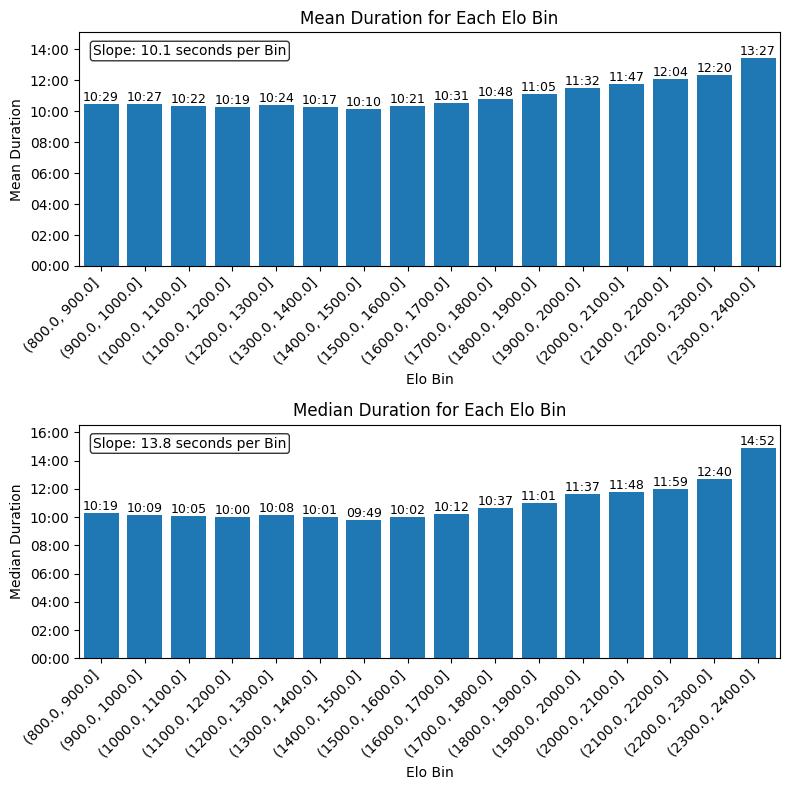

In [66]:
def format_time(seconds):
  minutes = seconds // 60
  seconds = seconds % 60
  return f'{int(minutes):02}:{int(seconds):02}'

def plot_bar_graph(df, ax, param): # assuming the dataframe has a column called elo_bin and one called duration
  bars = ax.bar(df['elo_bin'].astype(str), df['duration'])

  for bar in bars:
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, height, f'{format_time(round(height))}',
                 ha='center', va='bottom', fontsize=9)

  # because we want this text to appear within the graph, we have to set the y limits to be bigger than default
  y_max = df['duration'].max()
  buffer = 100
  ax.set_ylim(0, y_max + buffer)
  y_ticks = range(0, int(y_max) + 1 + buffer, 120)
  ax.set_yticks(y_ticks)
  ax.set_yticklabels([format_time(tick) for tick in y_ticks])

  # also, remove white space before the first and after the last bar
  ax.set_xlim(-0.5, len(df['elo_bin']) - 0.5)
  tick_positions = range(len(df_bin_means['elo_bin']))
  ax.set_xticks(tick_positions)
  ax.set_xticklabels(df_bin_means['elo_bin'].astype(str), rotation=45, ha='right')

  ax.set_xlabel("Elo Bin")
  ax.set_ylabel(param + " Duration")
  ax.set_title(param + " Duration for Each Elo Bin")

  # Finally, create a text box to include the best slope
  slope, intercept, r_value, p_value, std_err = linregress(df.index, df['duration']) # since we reset indices
  ax.text(0.02, 0.95, f'Slope: {slope:.1f} seconds per Bin', transform=ax.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.2'))


fig, axes = plt.subplots(2, 1, figsize=(8,8))

# call this helper function for both bin means and bin medians
plot_bar_graph(df_bin_means, axes[0], "Mean")
plot_bar_graph(df_bin_medians, axes[1], "Median")

plt.tight_layout()
plt.show()

Recall that these are 10+0 games, so the total possible duration is 20 minutes, 10 for each player. The graphs show that up until about 1500 elo, the mean and median durations do not change, and are roughly about 10 minutes total, a little less than half the total allotted time. However, both the mean and median begin increasing afterwards, which further supports the previous conclusion that more experienced players play games that last more time.

There are several possible explanations for the observed phenomenon.
1. More experienced players play games that last more moves, thereby taking up more time.
2. More experienced players spend more time per move. In other words, they play moves slower.

We look at the data for each of these possibilities.

### Question 3.1 - Do more experienced players play games that last more moves?

### Question 3.2 - Do more experienced players spend more time per move?